In [1]:
#This is a prediction model for the california housing project
#A project on prediction of median housing price for districts
#The error rate of this model should at least be less than 15%

In [2]:
#data manipulation and linear algebra libraries
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

#preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#feature engineering
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

#Model Selection and Training


Loading Data and Initial Exploratory Data Analysis

In [3]:
housing = pd.read_csv('housing.csv')
housing.info()
housing.describe() #statistical measures for the numerical values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
housing['ocean_proximity'].value_counts() 
#exploring the categorical variable

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

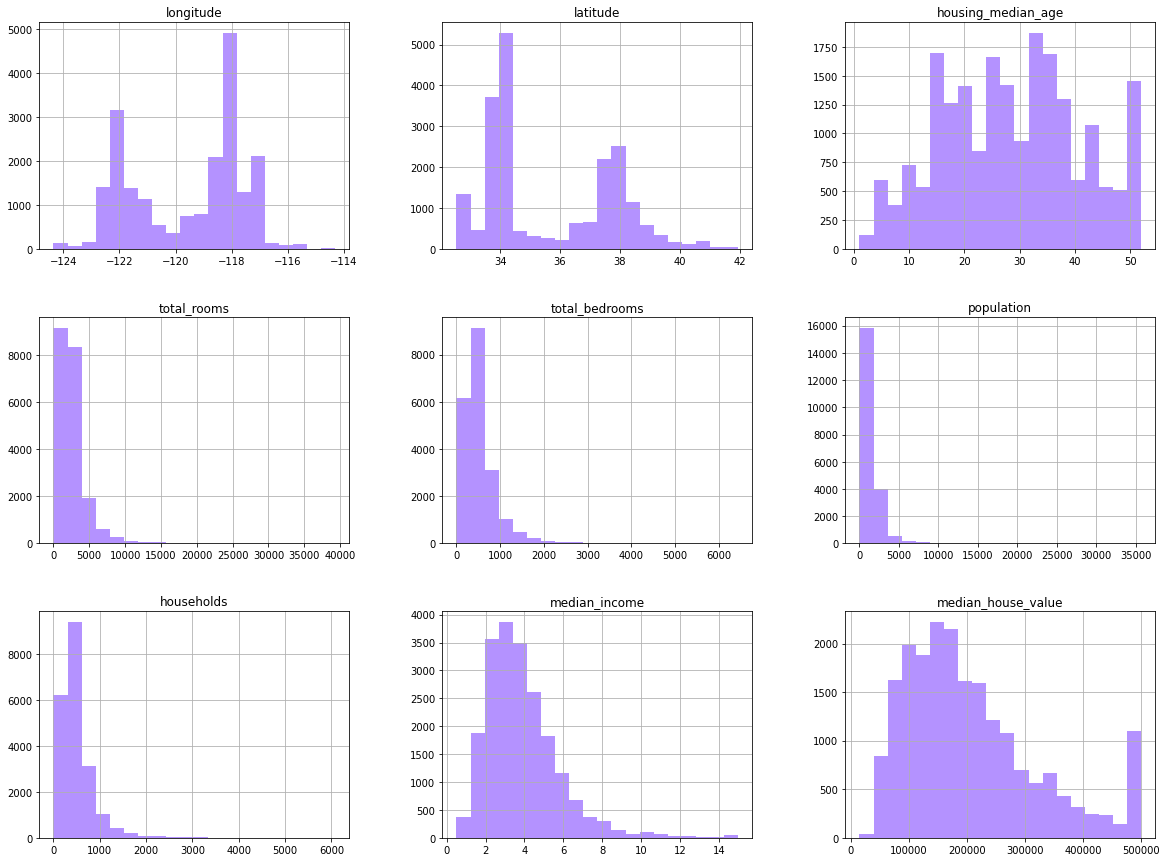

In [5]:
%matplotlib inline
housing.hist(bins=20, figsize=(20,15), color ='#b492ff')
plt.show()

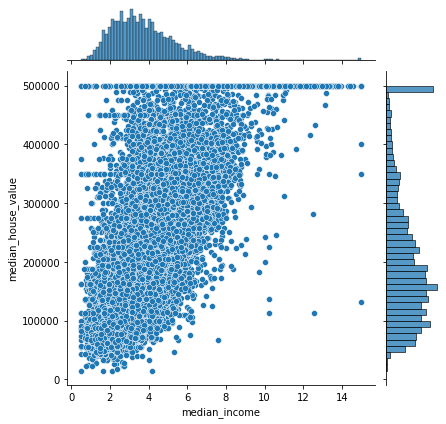

In [6]:
%matplotlib inline

sns.jointplot(x='median_income',y='median_house_value',data= housing,kind = 'scatter')

Training and Testing Set Splits

In [7]:
train_set,test_set = train_test_split(housing, test_size= 0.2, random_state=42)
print(train_set.shape, test_set.shape)

(16512, 10) (4128, 10)


<AxesSubplot:xlabel='median_income', ylabel='Count'>

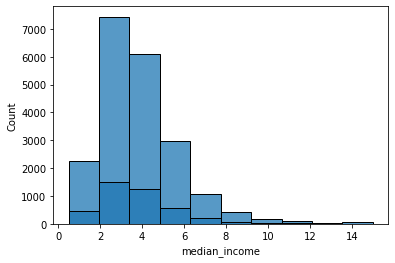

In [8]:
%matplotlib inline
sns.histplot(housing['median_income'], bins= 10)
sns.histplot(test_set['median_income'], bins= 10) ##checking if the test set is representative of the data

In [9]:
#fig, ax 


In [10]:
#creating a discrete income category attribute from median income
housing['income_cat'] = np.ceil(housing['median_income']/1.5) #rounding up
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace= True)
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [11]:
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
#This sss class creates a set of list of indexes given n_splits number of iterations

for train_index, test_index in sss.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#To check wheher the test data set has the same proportion to the entire data set
#To ensure it is representative of the data
print(round((housing["income_cat"].value_counts() / len(housing)),2))
round((strat_test_set['income_cat'].value_counts()/len(strat_test_set)),2)

3.0    0.35
2.0    0.32
4.0    0.18
5.0    0.11
1.0    0.04
Name: income_cat, dtype: float64


3.0    0.35
2.0    0.32
4.0    0.18
5.0    0.11
1.0    0.04
Name: income_cat, dtype: float64

In [12]:
#dropping the income_cat attribute to restore the original data
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace = True)

Training Set Data Visualization

In [13]:
#Exclusively using the train_set
housing = strat_train_set.copy()

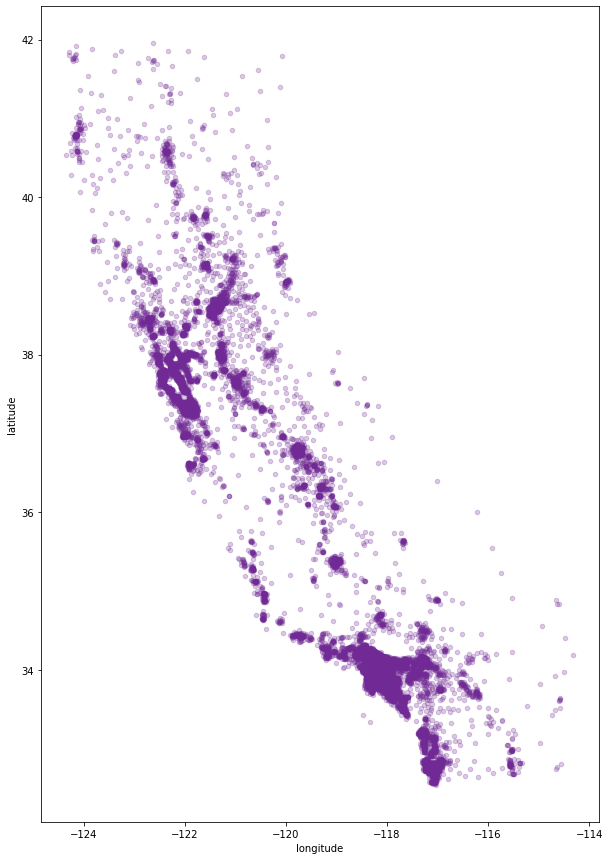

In [14]:
#mapping out the pop density 
%matplotlib inline
housing.plot(kind ='scatter', x = 'longitude', y = 'latitude',figsize =(10,15), color='#712a95', alpha = 0.25)
plt.show()

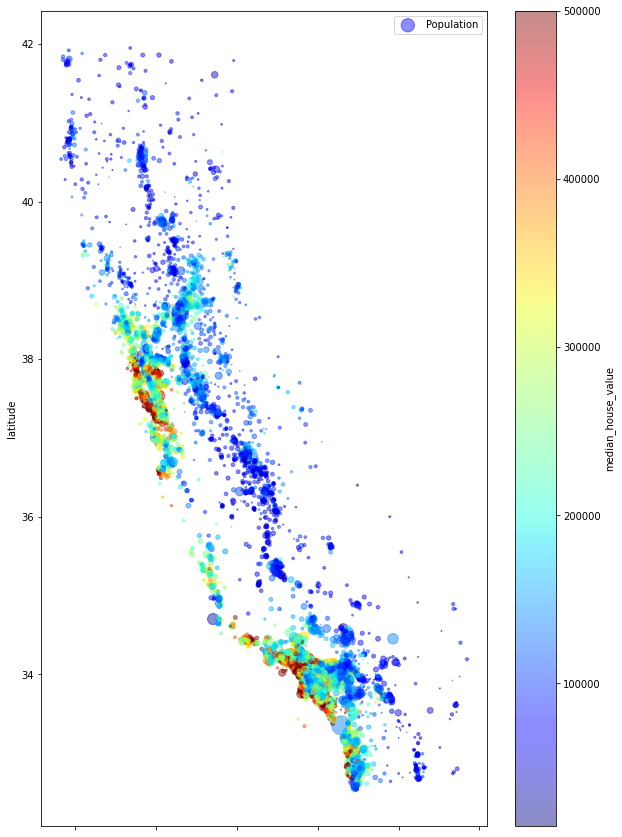

In [15]:
%matplotlib inline
housing.plot(kind ='scatter', x = 'longitude', y = 'latitude', figsize=(10,15),
             alpha = 0.45, s=housing['population']/100, label='Population',
            c='median_house_value', cmap='jet', colorbar=True)
plt.legend()

Feature Engineering & Data Cleaning

In [16]:
#looking for correlations between the target variable and other attributes
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

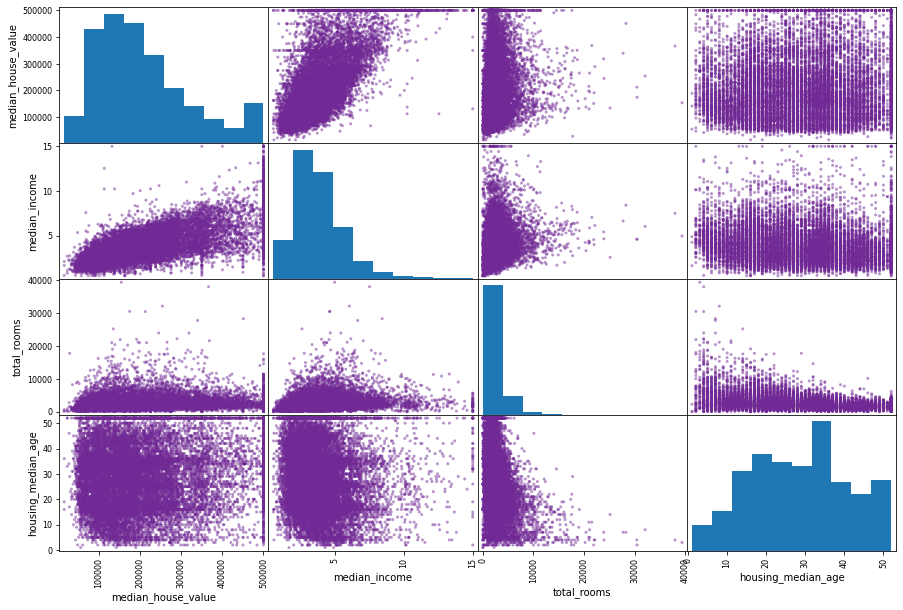

In [17]:
##selecting the attributes with the highest correlation
attrs = ['median_house_value', 'median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attrs], figsize =(15,10), color='#712a95')
plt.show()

In [18]:
#combining attributes
housing['rooms/household']= housing['total_rooms']/housing['households']
housing['bedroom_to_room']=housing['total_bedrooms']/housing['total_rooms']
housing["population_per_household"]=housing["population"]/housing["households"]

In [19]:
#checking correlation of new attributes
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms/household             0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedroom_to_room            -0.259952
Name: median_house_value, dtype: float64

In [20]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [21]:
#using sklearn Imputer to deal with missing values
imputer = SimpleImputer(strategy='median')

#dropping the ocean_proximity attr since median can only be computed on num values
housing_num = housing.drop('ocean_proximity', axis=1)
housing_num.isnull().sum()
#fitting the imputer instance to the data
imputer.fit(housing_num)
#transforming the training set by replacing the missing values w/ learned medians
X = imputer.transform(housing_num) #returns np array


In [22]:
#imputer.statistics_ stores the results of the imputer
imputer.statistics_ == housing_num.median().values

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [23]:
#converting the numpy array back to a df
housing_tr = pd.DataFrame(X, columns =housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


Handling of Text and categorical variables

In [25]:
encoder = LabelBinarizer(sparse_output = True)
housing_cat = housing['ocean_proximity']
#sparse_output converts the output from ndarray to sparse matrix ##saving on memory
housing_cat_1hot = encoder.fit_transform(housing_cat)

Custom Transformers for Feature Scaling & Transformation Pipelines

In [26]:
#a custom transformer for combining the numerical attributes
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_br_per_room = True):  ##setting the hyperparameter add_br_per_room to True
        self.add_br_per_room = add_br_per_room
    def fit(self = X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:,3] / X[:,6]
        pop_per_household = X[:,5] / X[:,6]
        if self.add_br_per_room:
            br_per_room = X[:,4] / X[:, 3]
            return np.c_[X, rooms_per_household, pop_per_household, br_per_room]
        else:
            return np.c_[X, rooms_per_household, pop_per_household]
        
# attr_adder  = CombinedAttributesAdder(add_br_per_room = False)
# housing_extra_attr = attr_adder.transform(housing_num)

In [27]:
##creating a custom transformer and a pipeline for numerical attributes

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)), #fit_transform()
    ('imputer', SimpleImputer(strategy='median')),#fit_transform()
    ('attrib_adder', CombinedAttributesAdder()),  #fit_transform()
    ('std_scaler',StandardScaler())               #fit()
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
print(type(housing_num_tr))

<class 'numpy.ndarray'>


In [28]:
cat_attribs = ['ocean_proximity']

#creating a custom transformer: MylabelBinarizer that takes 3 args instead of 2
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
         self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

##categorical variables pipeline
cat_pipeline =Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', MyLabelBinarizer()),
])
    


In [29]:
#joining transformers using FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape
#housing

(16512, 16)

Selecting and Trainig a Model

In [30]:
#Training a linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [31]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:\t',lin_reg.predict(some_data_prepared))
print('Labels:\t\t', list(some_labels))

Predictions:	 [ 85440. 305856. 152128. 186368. 244416.]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [32]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) #root mean square error
lin_rmse

68631.74609085765

In [33]:
#using decision tree to find any complex non-linear rlshp
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [34]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Performing K-fold Cross-Validation

In [35]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores =np.sqrt(-tree_scores)  #cross-validation expects a utility function hence the -scores
tree_rmse_scores

array([73315.01624209, 70085.98933115, 66556.26790911, 70802.1577634 ,
       71127.49496556, 76179.04766258, 71029.30215531, 72954.06770504,
       69088.57322052, 70354.85106917])

In [36]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [73315.01624209 70085.98933115 66556.26790911 70802.1577634
 71127.49496556 76179.04766258 71029.30215531 72954.06770504
 69088.57322052 70354.85106917]
Mean: 71149.27680239371
Standard deviation: 2459.381525073982


In [37]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error',cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71771.62978134 64114.99166359 67771.17124356 68590.58865048
 66886.06222989 72544.36137554 74009.65617539 68788.17156933
 66443.28836884 70156.1206811 ]
Mean: 69107.60417390525
Standard deviation: 2883.6302711183766


Ensemble Learning

In [38]:
#using a random forest generator
from sklearn.ensemble import RandomForestClassifier

forest_reg = RandomForestClassifier()
forest_reg.fit(housing_prepared, housing_labels)
forest_prediction = forest_reg.predict(housing_prepared)
foreste_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
display_scores(forest_rmse)


MemoryError: could not allocate 961806336 bytes